In [1]:
import random
#import mdp_utils
#import mdp_worlds
#import bayesian_irl
#from mdp import FeatureMDP
import copy
from scipy.stats import norm
import numpy as np
import math
import argparse

import sys
import os
import time
import yaml
import numpy as np
import random

SEED = 1234

# Get the current working directory of the notebook
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(current_directory)

# Add the parent directory to the system path
sys.path.append(parent_directory)


from env import gridworld_env
from env import gridworld_env2
from data_generation.generate_data import (generate_random_trajectory, 
                                           simulate_improvement_feedback_v2,
                                           simulate_human_estop_v2,
                                           generate_pairwise_comparisons)

In [2]:
feature_weights_list = np.load("/home/alilarian/Projects/Demonstration Sufficiency - V2/Feedback Sufficiency - Gridworld/main/grid_world_weights.npy")
print(len(feature_weights_list))




50


In [3]:
color_to_feature_map = {
    "red": [1, 0, 0],
    "blue": [0, 1, 0],
    "black": [0, 0, 1]  # 'black' indicates a terminal state
}

custom_grid_features = [
    ["blue", "red", "blue"],
    ["blue", "blue", "black"]
]


# Initialize environments with feature weights
envs = [gridworld_env2.NoisyLinearRewardFeaturizedGridWorldEnv(gamma=0.99,
    color_to_feature_map=color_to_feature_map,
    grid_features=custom_grid_features,
    custom_feature_weights=list(feat)) for feat in feature_weights_list[0:1]]

In [ ]:
# Fixing Seeds
random.seed(SEED)  # Fix Python's built-in random module
np.random.seed(SEED)  # Fix NumPy
os.environ['PYTHONHASHSEED'] = str(SEED)  # Ensure deterministic hashing

random_trajs = [generate_random_trajectory(envs[0], max_horizon=5, fixed_start=True) for i in range(1000000)]

#pairwise_comparisons = generate_pairwise_comparisons(envs[0], num_trajs=10, max_horizon=5, num_comparisons=5)
random_trajs
estops = [simulate_human_estop_v2(envs[0], j, beta=100, gamma=0.99) for j in random_trajs]

In [4]:
# Fixing Seeds
random.seed(SEED)  # Fix Python's built-in random module
np.random.seed(SEED)  # Fix NumPy
os.environ['PYTHONHASHSEED'] = str(SEED)  # Ensure deterministic hashing

import multiprocessing as mp
import pickle

# STEP 1: Parallel generation of random trajectories
def generate_one_trajectory(_):
    return generate_random_trajectory(envs[0], max_horizon=5, fixed_start=True)

# STEP 2: Parallel simulation of human estops
def simulate_one_estop(traj):
    return simulate_human_estop_v2(envs[0], traj, beta=100, gamma=0.99)

if __name__ == "__main__":
    num_samples = 3_000_000
    num_workers = mp.cpu_count()

    # Phase 1: Generate trajectories in parallel
    with mp.Pool(processes=num_workers) as pool:
        random_trajs = pool.map(generate_one_trajectory, range(num_samples))

    # Phase 2: Simulate estops in parallel
    with mp.Pool(processes=num_workers) as pool:
        estops = pool.map(simulate_one_estop, random_trajs)

    # Optionally: Save results
    with open("estops_1M.pkl", "wb") as f:
        pickle.dump(estops, f)


In [5]:
import numpy as np

normalized_unique_vectors = []

seen = set()

for traj, t in estops:
    # Compute features up to t
    features_up_to_t = [envs[0].get_state_feature(s) for s, _ in traj[:t+1]]
    sum_feat_up_to_t = np.sum(features_up_to_t, axis=0)

    # Compute features for full trajectory
    full_traj_features = [envs[0].get_state_feature(s) for s, _ in traj]
    traj_feat = np.sum(full_traj_features, axis=0)

    # Difference
    diff = traj_feat - sum_feat_up_to_t

    # Normalize (L2 norm)
    norm = np.linalg.norm(diff)
    if norm == 0:
        normalized = np.zeros_like(diff)
    else:
        normalized = diff / norm

    # Convert to tuple for hashing and check uniqueness
    key = tuple(np.round(normalized, decimals=6))  # rounding to avoid float precision issues
    if key not in seen:
        seen.add(key)
        normalized_unique_vectors.append(normalized)

# Now `normalized_unique_vectors` contains only the unique normalized feature difference vectors


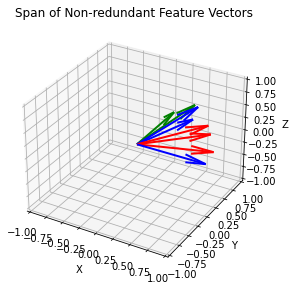

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `non_redundant` contains your basis vectors (3D)
non_redundant = np.array(normalized_unique_vectors)  # shape (k, 3)

# Setup 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot origin
origin = np.zeros(3)

# Plot each basis vector
colors = ['r', 'g', 'b']
for i, vec in enumerate(non_redundant):
    ax.quiver(*origin, *vec, color=colors[i % 3], linewidth=2)

# Optionally plot the plane if you have 2 basis vectors (span of a plane)
if len(non_redundant) == 2:
    v1, v2 = non_redundant
    s = np.linspace(-1, 1, 10)
    t = np.linspace(-1, 1, 10)
    S, T = np.meshgrid(s, t)
    plane = np.outer(S, v1) + np.outer(T, v2)
    X = plane[:, 0].reshape(10, 10)
    Y = plane[:, 1].reshape(10, 10)
    Z = plane[:, 2].reshape(10, 10)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='gray')

# Set axes limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Span of Non-redundant Feature Vectors')
plt.tight_layout()
plt.show()


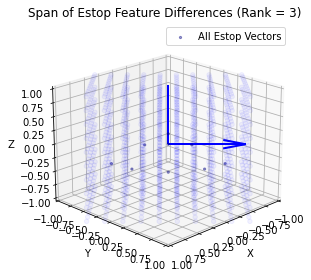

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

# ---- INPUT ----
# Assumes you already have this from your estop pipeline
estop_vectors = np.array(normalized_unique_vectors)  # shape (N, 3)

# ---- STEP 1: Get linearly independent basis using SVD ----
U, S, Vt = svd(estop_vectors)
rank = np.sum(S > 1e-6)
basis = Vt[:rank]  # shape: (rank, 3)

# ---- STEP 2: Plot Setup ----
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
origin = np.zeros(3)
res = 20  # resolution of surface or volume grid

# ---- STEP 3: Plot Basis Vectors ----
for i, vec in enumerate(basis):
    ax.quiver(*origin, *vec, color='blue', linewidth=2)

# ---- STEP 4: Visualize Span in Blue ----
if rank == 1:
    t = np.linspace(-1, 1, res)
    line = np.outer(t, basis[0])
    ax.plot(line[:, 0], line[:, 1], line[:, 2], color='blue', alpha=0.3)

elif rank == 2:
    s = np.linspace(-1, 1, res)
    t = np.linspace(-1, 1, res)
    S, T = np.meshgrid(s, t)
    plane = np.outer(S.ravel(), basis[0]) + np.outer(T.ravel(), basis[1])
    X = plane[:, 0].reshape(res, res)
    Y = plane[:, 1].reshape(res, res)
    Z = plane[:, 2].reshape(res, res)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='blue')

elif rank >= 3:
    s = np.linspace(-1, 1, 10)
    t = np.linspace(-1, 1, 10)
    u = np.linspace(-1, 1, 10)

    pts = []
    for a in s:
        for b in t:
            for c in u:
                pt = a * basis[0] + b * basis[1] + c * basis[2]
                pts.append(pt)
    pts = np.array(pts)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], alpha=0.05, color='blue')

# ---- STEP 5: Overlay All Normalized Estop Vectors (Optional) ----
ax.scatter(estop_vectors[:, 0], estop_vectors[:, 1], estop_vectors[:, 2],
           color='navy', s=5, alpha=0.4, label='All Estop Vectors')

# ---- STEP 6: Aesthetic Settings ----
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=45)
plt.title(f'Span of Estop Feature Differences (Rank = {rank})')
plt.legend()
plt.tight_layout()
plt.show()

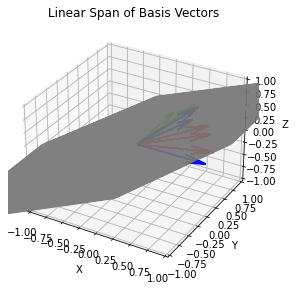

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Basis vectors (3D), assumed to be normalized_unique_vectors forming a basis
basis = np.array(normalized_unique_vectors)  # shape: (k, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

origin = np.zeros(3)
colors = ['r', 'g', 'b']

# Plot the basis vectors
for i, vec in enumerate(basis):
    ax.quiver(*origin, *vec, color=colors[i % len(colors)], linewidth=2)

# Visualize the span depending on number of basis vectors
res = 200
if len(basis) == 1:
    # Line span
    t = np.linspace(-1, 1, res)
    line = np.outer(t, basis[0])
    ax.plot(line[:, 0], line[:, 1], line[:, 2], color='gray', alpha=0.6)

elif len(basis) == 2:
    # Plane span
    s = np.linspace(-1, 1, res)
    t = np.linspace(-1, 1, res)
    S, T = np.meshgrid(s, t)
    plane = np.outer(S.ravel(), basis[0]) + np.outer(T.ravel(), basis[1])
    X = plane[:, 0].reshape(res, res)
    Y = plane[:, 1].reshape(res, res)
    Z = plane[:, 2].reshape(res, res)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='gray')

elif len(basis) >= 3:
    # Full 3D span: sample many linear combinations in a cube
    s = np.linspace(-1, 1, res)
    t = np.linspace(-1, 1, res)
    u = np.linspace(-1, 1, res)

    pts = []
    for a in s:
        for b in t:
            for c in u:
                pt = a * basis[0] + b * basis[1] + c * basis[2]
                pts.append(pt)
    pts = np.array(pts)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], alpha=0.05, color='gray')

# Set axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Linear Span of Basis Vectors')
plt.tight_layout()
plt.show()

Rank of estop span: 3


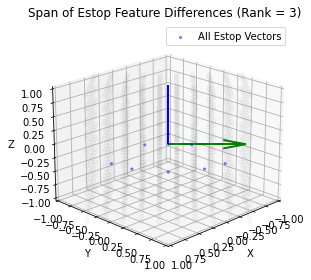

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

# ---- INPUT ----
# normalized_unique_vectors = list of 3D vectors from estop feature differences
estop_vectors = np.array(normalized_unique_vectors)  # shape (N, 3)

# ---- STEP 1: Extract Basis Using SVD ----
U, S, Vt = svd(estop_vectors)
rank = np.sum(S > 1e-6)
basis = Vt[:rank]  # linearly independent directions (shape: (rank, 3))

print(f"Rank of estop span: {rank}")

# ---- STEP 2: Plot Setup ----
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
origin = np.zeros(3)
res = 20  # resolution

# ---- STEP 3: Plot Basis Vectors ----
colors = ['r', 'g', 'b']
for i, vec in enumerate(basis):
    ax.quiver(*origin, *vec, color=colors[i % len(colors)], linewidth=2)

# ---- STEP 4: Visualize the Span ----
if rank == 1:
    t = np.linspace(-1, 1, res)
    line = np.outer(t, basis[0])
    ax.plot(line[:, 0], line[:, 1], line[:, 2], color='gray', alpha=0.6)

elif rank == 2:
    s = np.linspace(-1, 1, res)
    t = np.linspace(-1, 1, res)
    S, T = np.meshgrid(s, t)
    plane = np.outer(S.ravel(), basis[0]) + np.outer(T.ravel(), basis[1])
    X = plane[:, 0].reshape(res, res)
    Y = plane[:, 1].reshape(res, res)
    Z = plane[:, 2].reshape(res, res)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='gray')

elif rank >= 3:
    s = np.linspace(-1, 1, 10)
    t = np.linspace(-1, 1, 10)
    u = np.linspace(-1, 1, 10)

    pts = []
    for a in s:
        for b in t:
            for c in u:
                pt = a * basis[0] + b * basis[1] + c * basis[2]
                pts.append(pt)
    pts = np.array(pts)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], alpha=0.05, color='gray')

# ---- STEP 5: Overlay All Estop Vectors (Optional) ----
ax.scatter(estop_vectors[:, 0], estop_vectors[:, 1], estop_vectors[:, 2],
           color='blue', s=5, alpha=0.4, label='All Estop Vectors')

# ---- STEP 6: Axis and Style ----
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=45)
plt.title(f'Span of Estop Feature Differences (Rank = {rank})')
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
pairwise_comparisons = [([(0,1), (3,3), (4,3), (5,None)], [(0,1), (3,0), (0,1), (3,0)]), 
                        ([(0,1), (3,3), (4,3), (5,None)], [(0,3), (1,3), (2,1), (5,None)]),
                       ([(0,1), (3,3), (4,3), (5,None)], [(0,3), (1,1), (4,3), (5,None)])]
pairwise_comparisons += generate_pairwise_comparisons(envs[0], num_trajs=10, max_horizon=5, num_comparisons=5)

In [17]:
def process_comparison(_):
    comparisons = generate_pairwise_comparisons(envs[0], num_trajs=10, max_horizon=5, num_comparisons=1)
    
    diffs = []
    for preferred, other in comparisons:
        # Get features for each trajectory
        preferred_feats = [envs[0].get_state_feature(s) for s, _ in preferred]
        other_feats = [envs[0].get_state_feature(s) for s, _ in other]

        # Sum of features (trajectory feature vector)
        preferred_sum = np.sum(preferred_feats, axis=0)
        other_sum = np.sum(other_feats, axis=0)

        diff = preferred_sum - other_sum

        # Normalize
        norm = np.linalg.norm(diff)
        if norm == 0:
            normalized = np.zeros_like(diff)
        else:
            normalized = diff / norm

        # Round to avoid float precision issues
        key = tuple(np.round(normalized, decimals=6))
        diffs.append(key)

    return diffs

In [18]:
import multiprocessing as mp

if __name__ == "__main__":
    total_comparisons = 100_0000
    num_workers = mp.cpu_count()

    with mp.Pool(processes=num_workers) as pool:
        all_comparisons = pool.map(process_comparison, range(total_comparisons))


In [19]:
normalized_unique_comparison_vectors = []
seen = set()

for diff_list in all_comparisons:
    for key in diff_list:
        if key not in seen:
            seen.add(key)
            normalized_unique_comparison_vectors.append(np.array(key))


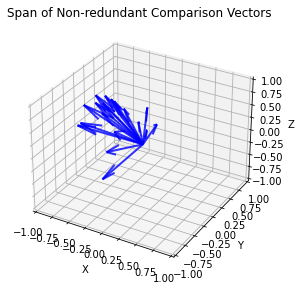

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use your linearly independent comparison vectors
non_redundant_comparisons = np.array(normalized_unique_comparison_vectors)  # shape (k, 3)

# Setup plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
origin = np.zeros(3)

# Plot each comparison vector as a blue arrow from origin
for i, vec in enumerate(non_redundant_comparisons):
    ax.quiver(*origin, *vec, color='blue', linewidth=2, alpha=0.8)

# If exactly 2 linearly independent vectors, show their span as a surface
if len(non_redundant_comparisons) == 2:
    v1, v2 = non_redundant_comparisons
    s = np.linspace(-1, 1, 10)
    t = np.linspace(-1, 1, 10)
    S, T = np.meshgrid(s, t)
    plane = np.outer(S, v1) + np.outer(T, v2)
    X = plane[:, 0].reshape(10, 10)
    Y = plane[:, 1].reshape(10, 10)
    Z = plane[:, 2].reshape(10, 10)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='lightblue')

# Axes settings
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Span of Non-redundant Comparison Vectors')
plt.tight_layout()
plt.show()

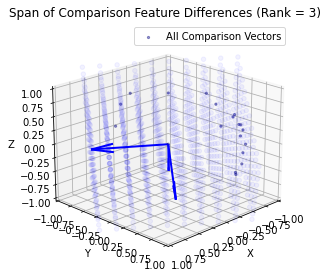

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

# ---- INPUT ----
# Assumes you already have this
comparison_vectors = np.array(normalized_unique_comparison_vectors)  # shape (N, 3)

# ---- STEP 1: Get linearly independent basis using SVD ----
U, S, Vt = svd(comparison_vectors)
rank = np.sum(S > 1e-6)
basis = Vt[:rank]  # shape: (rank, 3)

# ---- STEP 2: Plot Setup ----
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
origin = np.zeros(3)
res = 200

# ---- STEP 3: Plot Basis Vectors ----
for i, vec in enumerate(basis):
    ax.quiver(*origin, *vec, color='blue', linewidth=2)

# ---- STEP 4: Visualize Span in Blue ----
if rank == 1:
    t = np.linspace(-1, 1, res)
    line = np.outer(t, basis[0])
    ax.plot(line[:, 0], line[:, 1], line[:, 2], color='blue', alpha=0.3)

elif rank == 2:
    s = np.linspace(-1, 1, res)
    t = np.linspace(-1, 1, res)
    S, T = np.meshgrid(s, t)
    plane = np.outer(S.ravel(), basis[0]) + np.outer(T.ravel(), basis[1])
    X = plane[:, 0].reshape(res, res)
    Y = plane[:, 1].reshape(res, res)
    Z = plane[:, 2].reshape(res, res)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='blue')

elif rank >= 3:
    s = np.linspace(-1, 1, 10)
    t = np.linspace(-1, 1, 10)
    u = np.linspace(-1, 1, 10)

    pts = []
    for a in s:
        for b in t:
            for c in u:
                pt = a * basis[0] + b * basis[1] + c * basis[2]
                pts.append(pt)
    pts = np.array(pts)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], alpha=0.05, color='blue')

# ---- STEP 5: Overlay All Normalized Comparison Vectors (Optional) ----
ax.scatter(comparison_vectors[:, 0], comparison_vectors[:, 1], comparison_vectors[:, 2],
           color='navy', s=5, alpha=0.4, label='All Comparison Vectors')

# ---- STEP 6: Aesthetic Settings ----
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=45)
plt.title(f'Span of Comparison Feature Differences (Rank = {rank})')
plt.legend()
plt.tight_layout()
plt.show()

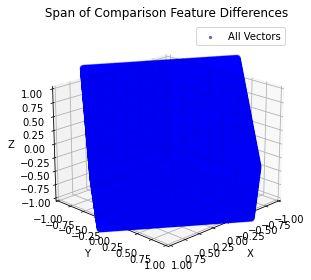

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

origin = np.zeros(3)
res = 200  # resolution

# Plot the basis vectors
colors = ['r', 'g', 'b']
for i, vec in enumerate(basis):
    ax.quiver(*origin, *vec, color=colors[i % len(colors)], linewidth=2)

#  Visualize the span in blue
if rank == 1:
    t = np.linspace(-1, 1, res)
    line = np.outer(t, basis[0])
    ax.plot(line[:, 0], line[:, 1], line[:, 2], color='blue', alpha=0.6)

elif rank == 2:
    s = np.linspace(-1, 1, res)
    t = np.linspace(-1, 1, res)
    S, T = np.meshgrid(s, t)
    plane = np.outer(S.ravel(), basis[0]) + np.outer(T.ravel(), basis[1])
    X = plane[:, 0].reshape(res, res)
    Y = plane[:, 1].reshape(res, res)
    Z = plane[:, 2].reshape(res, res)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='blue')

elif rank >= 3:
    s = np.linspace(-1, 1, res)
    t = np.linspace(-1, 1, res)
    u = np.linspace(-1, 1, res)

    pts = []
    for a in s:
        for b in t:
            for c in u:
                pt = a * basis[0] + b * basis[1] + c * basis[2]
                pts.append(pt)
    pts = np.array(pts)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], alpha=0.05, color='blue')

# Overlay all normalized comparison vectors
all_vecs = np.array(normalized_unique_comparison_vectors)
ax.scatter(all_vecs[:, 0], all_vecs[:, 1], all_vecs[:, 2], color='navy', s=5, alpha=0.5, label='All Vectors')

# Axis lines through origin (optional)
ax.plot([-1, 1], [0, 0], [0, 0], color='black', linewidth=0.5)  # X
ax.plot([0, 0], [-1, 1], [0, 0], color='black', linewidth=0.5)  # Y
ax.plot([0, 0], [0, 0], [-1, 1], color='black', linewidth=0.5)  # Z

# Labels and view
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=45)  # Optional: adjust view
plt.title(' Span of Comparison Feature Differences')
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
from scipy.linalg import svd
import numpy as np

# Get rank of estop vectors
estop_matrix = np.array(normalized_unique_vectors)
_, S1, _ = svd(estop_matrix)
rank_estop = np.sum(S1 > 1e-6)

# Get rank of comparison vectors
comparison_matrix = np.array(normalized_unique_comparison_vectors)
_, S2, _ = svd(comparison_matrix)
rank_comparison = np.sum(S2 > 1e-6)

print(f"Estop Span Rank: {rank_estop}")
print(f"Comparison Span Rank: {rank_comparison}")



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import numpy as np

# Get bases via SVD
estop_matrix = np.array(normalized_unique_vectors)
_, _, Vt_estop = svd(estop_matrix)
basis_estop = Vt_estop[:np.sum(S1 > 1e-6)]

comparison_matrix = np.array(normalized_unique_comparison_vectors)
_, _, Vt_comp = svd(comparison_matrix)
basis_comp = Vt_comp[:np.sum(S2 > 1e-6)]

# Plot setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
origin = np.zeros(3)
res = 10

# Estop span (in blue)
for vec in basis_estop:
    ax.quiver(*origin, *vec, color='blue', linewidth=2, label='Estop Basis')

# Comparison span (in red)
for vec in basis_comp:
    ax.quiver(*origin, *vec, color='red', linewidth=2, alpha=0.7, label='Comparison Basis')

# Optionally overlay actual vector clouds
ax.scatter(estop_matrix[:, 0], estop_matrix[:, 1], estop_matrix[:, 2],
           color='blue', s=3, alpha=0.3, label='Estop Vectors')
ax.scatter(comparison_matrix[:, 0], comparison_matrix[:, 1], comparison_matrix[:, 2],
           color='red', s=3, alpha=0.3, label='Comparison Vectors')

# Axis setup
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=45)
plt.title("Span Comparison: Estop vs Comparison Vectors")
#plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.linalg import svd
import plotly.graph_objects as go

# --- Load your vector sets ---
estop_vectors = np.array(normalized_unique_vectors)
comparison_vectors = np.array(normalized_unique_comparison_vectors)

# --- Extract basis using SVD ---
_, S_estop, Vt_estop = svd(estop_vectors)
rank_estop = np.sum(S_estop > 1e-6)
basis_estop = Vt_estop[:rank_estop]

_, S_comp, Vt_comp = svd(comparison_vectors)
rank_comp = np.sum(S_comp > 1e-6)
basis_comp = Vt_comp[:rank_comp]

# --- Plot ---
fig = go.Figure()

# Plot estop vectors (blue dots)
fig.add_trace(go.Scatter3d(
    x=estop_vectors[:, 0], y=estop_vectors[:, 1], z=estop_vectors[:, 2],
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.5),
    name='Estop Vectors'
))

# Plot comparison vectors (red dots)
fig.add_trace(go.Scatter3d(
    x=comparison_vectors[:, 0], y=comparison_vectors[:, 1], z=comparison_vectors[:, 2],
    mode='markers',
    marker=dict(size=2, color='red', opacity=0.5),
    name='Comparison Vectors'
))

# Plot estop basis vectors as arrows (blue)
for vec in basis_estop:
    fig.add_trace(go.Cone(
        x=[0], y=[0], z=[0],
        u=[vec[0]], v=[vec[1]], w=[vec[2]],
        colorscale='Blues',
        sizemode="absolute",
        sizeref=0.5,
        anchor="tail",
        name="Estop Basis"
    ))

# Plot comparison basis vectors as arrows (red)
for vec in basis_comp:
    fig.add_trace(go.Cone(
        x=[0], y=[0], z=[0],
        u=[vec[0]], v=[vec[1]], w=[vec[2]],
        colorscale='Reds',
        sizemode="absolute",
        sizeref=0.5,
        anchor="tail",
        name="Comparison Basis"
    ))

# Layout settings
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1, 1], title='X'),
        yaxis=dict(range=[-1, 1], title='Y'),
        zaxis=dict(range=[-1, 1], title='Z'),
        aspectmode='cube'
    ),
    title=f'Estop vs Comparison Span (Rank: Estop={rank_estop}, Comparison={rank_comp})',
    showlegend=True,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [ ]:
! pip install nbformat